<a href="https://colab.research.google.com/github/eterniacockers/BASH-Risk/blob/main/AHP_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd

# Upload file
uploaded = files.upload()

Saving AHP Matrix.xlsx to AHP Matrix.xlsx


In [ ]:
# ✅ Import libraries
import pandas as pd
import numpy as np
from numpy.linalg import eig


# ✅ Read Excel file
file_path = list(uploaded.keys())[0]  # Grab the uploaded filename
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

# ✅ Define expected features
expected_features = [
    "Wet_Bulb", "Altimeter", "Precipitation", "Humidity",
    "Sky_Cond", "Visibility", "Wind_Dir", "Wind_Speed"
]

# ✅ Initialize storage
priority_vectors = {}  # Will store final feature weights for each respondent
consistency_ratios = {}  # (Optional) Store CR for each matrix
random_index = {  # Standard Random Index (RI) table for 8x8 matrices
    1: 0.00, 2: 0.00, 3: 0.58, 4: 0.90, 5: 1.12,
    6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49
}

# ✅ Function: Calculate Consistency Index (CI) and Consistency Ratio (CR)
def calculate_consistency(matrix, priority_vector):
    n = matrix.shape[0]
    weighted_sum = np.dot(matrix, priority_vector)
    lambda_max = np.sum(weighted_sum / priority_vector) / n
    CI = (lambda_max - n) / (n - 1)
    CR = CI / random_index.get(n, 1.41)  # Default RI for 8 if not found
    return CI, CR

# ✅ Main Loop: process each respondent
for sheet in sheet_names:
    try:
        df = pd.read_excel(file_path, sheet_name=sheet, index_col=0)
        df = df.dropna(how="all").dropna(axis=1, how="all")  # Drop fully blank rows/cols

        if df.empty:
            continue  # Skip blank sheets

        # Make sure order is correct
        df = df.reindex(index=expected_features, columns=expected_features)

       # Convert to numpy array and force numeric
        matrix = df.values
        matrix = matrix.astype(np.float64)  # 🔥 Force all entries to float

        # Calculate priority vector (Eigenvector method)
        eigenvalues, eigenvectors = eig(matrix)
        max_index = np.argmax(np.real(eigenvalues))
        principal_eigenvector = np.real(eigenvectors[:, max_index])
        normalized_priority_vector = principal_eigenvector / principal_eigenvector.sum()

        priority_vectors[sheet] = normalized_priority_vector

        # Optional: Calculate CI and CR
        CI, CR = calculate_consistency(matrix, normalized_priority_vector)
        consistency_ratios[sheet] = CR

    except Exception as e:
        print(f"⚠️ Error processing {sheet}: {e}")


In [ ]:
# ✅ Create DataFrame
priority_df = pd.DataFrame(priority_vectors).T
priority_df.columns = expected_features

# Preview the weights
print(priority_df.round(4))


    Wet_Bulb  Altimeter  Precipitation  Humidity  Sky_Cond  Visibility  \
1     0.0539     0.0292         0.0774    0.0372    0.1362      0.2885   
2     0.0679     0.1176         0.2682    0.0813    0.0898      0.0826   
3     0.0473     0.0094         0.1951    0.0397    0.0782      0.2605   
4     0.0890     0.0342         0.3239    0.0582    0.2566      0.1228   
5     0.0342     0.1865         0.2194    0.0628    0.1345      0.1329   
6     0.0962     0.0508         0.1961    0.0641    0.0851      0.1902   
7     0.0831     0.1054         0.2799    0.0419    0.0717      0.1867   
8     0.0795     0.0441         0.2587    0.0231    0.1264      0.1712   
9     0.0836     0.2206         0.1588    0.0885    0.1475      0.1003   
10    0.2189     0.0339         0.4568    0.0316    0.0413      0.1174   
11    0.1091     0.1136         0.1304    0.0906    0.1581      0.1207   
12    0.0247     0.0502         0.1225    0.0402    0.1013      0.1350   
13    0.0757     0.0378         0.3993

In [ ]:
# ✅ Average feature importance across all respondents
average_weights = priority_df.mean().sort_values(ascending=False)

print("\nAverage Feature Weights (Across All Experts):")
print(average_weights.round(4))


Average Feature Weights (Across All Experts):
Precipitation    0.2167
Wind_Speed       0.1606
Visibility       0.1549
Wind_Dir         0.1170
Sky_Cond         0.1106
Wet_Bulb         0.0940
Altimeter        0.0801
Humidity         0.0660
dtype: float64


In [ ]:
# ✅ Export the average weights
average_weights_df = average_weights.to_frame(name="Average_Importance")
average_weights_df.index.name = "Feature"

# ✅ Save to CSV
average_weights_df.to_csv("Average_Feature_Importance_AHP.csv")

# ✅ Download the file (if you're in Colab)
from google.colab import files
files.download("Average_Feature_Importance_AHP.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ Convert consistency ratios into DataFrame
cr_df = pd.DataFrame.from_dict(consistency_ratios, orient="index", columns=["Consistency_Ratio"])

print("\nConsistency Ratios (CR) per Respondent:")
print(cr_df.round(4))




Consistency Ratios (CR) per Respondent:
    Consistency_Ratio
1              0.8436
2              0.3524
3              0.4818
4              0.4653
5              0.5017
6              0.5106
7              0.5429
8              0.4842
9              0.2295
10             0.3750
11             0.4354
12             0.5060
13             0.4558
14             0.2444
15             0.2349
16             0.4381
17             0.3382
18             0.3805
19             0.2946
20             0.6058
21             0.4255
22             0.4668
23             0.5057
24             0.4485
25             0.4267
26             0.3167
27             0.0000
28             0.6906
29             0.3179


In [ ]:
# ✅ Make sure Consistency Ratios DataFrame is ready
cr_df.index.name = "Respondent_ID"

# ✅ Save to CSV
cr_df.to_csv("Consistency_Ratios_AHP.csv")

# ✅ Download (if working in Colab)
from google.colab import files
files.download("Consistency_Ratios_AHP.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# ✅ Create DataFrame
priority_df = pd.DataFrame(priority_vectors).T
priority_df.columns = expected_features

# ✅ Save to CSV
priority_df.to_csv("Respondent_Feature_Weights.csv", index_label="Respondent_ID")

# ✅ Download
files.download("Respondent_Feature_Weights.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

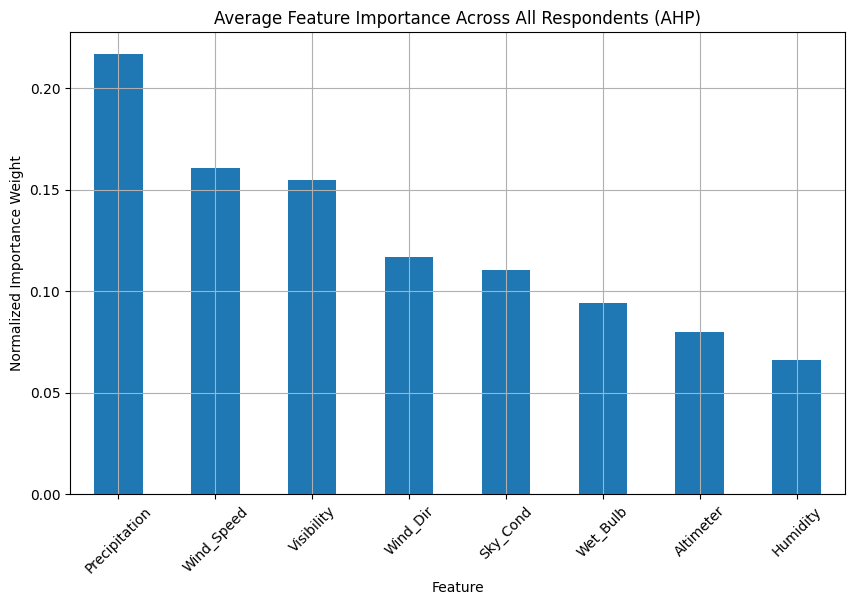

In [ ]:
import matplotlib.pyplot as plt

# ✅ Average feature importance
average_weights = priority_df.mean().sort_values(ascending=False)

# ✅ Bar Plot
plt.figure(figsize=(10,6))
average_weights.plot(kind='bar')
plt.title("Average Feature Importance Across All Respondents (AHP)")
plt.ylabel("Normalized Importance Weight")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Add coding to separate out experience level and location to see if it improves CR.

In [ ]:
# Read first respondent sheet
df = pd.read_excel(file_path, sheet_name=sheet_names[0], header=None)
print(df.head(20))


                0         1          2              3         4         5  \
0               1  Wet_Bulb  Altimeter  Precipitation  Humidity  Sky_Cond   
1        Wet_Bulb         1          1              3         5  0.666667   
2       Altimeter         1          1       0.444444  0.777778  0.555556   
3   Precipitation  0.333333          6              1         5  0.333333   
4        Humidity  0.555556          3       0.555556         1  0.555556   
5        Sky_Cond         4          5              7         5         1   
6      Visibility         6          8              5         8         7   
7        Wind_Dir         3          1       0.666667         1  0.444444   
8      Wind_Speed         8          8              8         5         7   
9             NaN       NaN        NaN            NaN       NaN       NaN   
10            NaN       NaN        NaN            NaN       NaN       NaN   
11            NaN       NaN        NaN            NaN       NaN       NaN   

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import eig

file_path = list(uploaded.keys())[0]
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

expected_features = [
    "Wet_Bulb", "Altimeter", "Precipitation", "Humidity",
    "Sky_Cond", "Visibility", "Wind_Dir", "Wind_Speed"
]

priority_vectors = {}
consistency_ratios = {}
metadata_records = []

random_index = {
    1: 0.00, 2: 0.00, 3: 0.58, 4: 0.90, 5: 1.12,
    6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49
}

def calculate_consistency(matrix, priority_vector):
    n = matrix.shape[0]
    weighted_sum = np.dot(matrix, priority_vector)
    lambda_max = np.sum(weighted_sum / priority_vector) / n
    CI = (lambda_max - n) / (n - 1)
    CR = CI / random_index.get(n, 1.41)
    return CI, CR

for sheet in sheet_names:
    try:
        df = pd.read_excel(file_path, sheet_name=sheet, header=None)

        if df.empty:
            continue

        # ✅ Step 1: Extract metadata safely (before any drop)
        years = int(df.iloc[12, 1])  # Row 13
        location = int(df.iloc[13, 1])  # Row 14
        flyway = str(df.iloc[14, 1])  # Row 15

        metadata_records.append({
            "Respondent_ID": sheet,
            "Years": years,
            "Location": location,
            "Flyway": flyway
        })

        # ✅ Step 2: Drop blank rows now
        df = df.dropna(how="all", axis=0).dropna(how="all", axis=1)

        # ✅ Step 3: Extract matrix
        feature_names = df.iloc[1:9, 0].tolist()
        matrix_data = df.iloc[1:9, 1:9]

        matrix_df = pd.DataFrame(matrix_data.values, index=feature_names, columns=expected_features)
        matrix = matrix_df.values.astype(np.float64)

        # ✅ Step 4: Calculate eigenvector priorities
        eigenvalues, eigenvectors = eig(matrix)
        max_index = np.argmax(np.real(eigenvalues))
        principal_eigenvector = np.real(eigenvectors[:, max_index])
        normalized_priority_vector = principal_eigenvector / principal_eigenvector.sum()

        priority_vectors[sheet] = normalized_priority_vector

        # ✅ Step 5: Consistency Index
        CI, CR = calculate_consistency(matrix, normalized_priority_vector)
        consistency_ratios[sheet] = CR

    except Exception as e:
        print(f"⚠️ Error processing {sheet}: {e}")






⚠️ Error processing 30: cannot convert float NaN to integer


In [ ]:
# ✅ Create DataFrames first
priority_df = pd.DataFrame(priority_vectors).T
priority_df.columns = expected_features

metadata_df = pd.DataFrame(metadata_records)
metadata_df.set_index("Respondent_ID", inplace=True)

# ✅ Now merge them
full_df = priority_df.merge(metadata_df, left_index=True, right_index=True)

# ✅ Confirm
print(full_df.head())


   Wet_Bulb  Altimeter  Precipitation  Humidity  Sky_Cond  Visibility  \
1  0.053932   0.029194       0.077391  0.037249  0.136198    0.288514   
2  0.067868   0.117603       0.268163  0.081278  0.089762    0.082620   
3  0.047302   0.009363       0.195129  0.039694  0.078232    0.260472   
4  0.088966   0.034172       0.323935  0.058206  0.256553    0.122810   
5  0.034191   0.186480       0.219406  0.062812  0.134454    0.132920   

   Wind_Dir  Wind_Speed  Years  Location Flyway  
1  0.136899    0.240623      3         1      2  
2  0.137958    0.154747      3         1      4  
3  0.145505    0.224303      3         1      4  
4  0.023824    0.091533      2         2      4  
5  0.069802    0.159934      2         1      4  


In [ ]:
# ✅ Group by Years (Experience)
experience_group_means = full_df.groupby("Years")[priority_df.columns].mean()

print("\nAverage Feature Importance by Experience Group:")
print(experience_group_means.round(4))

# ✅ Group by Location (North/South)
location_group_means = full_df.groupby("Location")[priority_df.columns].mean()

print("\nAverage Feature Importance by Location Group:")
print(location_group_means.round(4))

# ✅ Group by Flyway
flyway_group_means = full_df.groupby("Flyway")[priority_df.columns].mean()

print("\nAverage Feature Importance by Flyway Group:")
print(flyway_group_means.round(4))



Average Feature Importance by Experience Group:
       Wet_Bulb  Altimeter  Precipitation  Humidity  Sky_Cond  Visibility  \
Years                                                                       
1        0.1119     0.0867         0.2166    0.0887    0.1022      0.1695   
2        0.1103     0.0798         0.2693    0.0672    0.1195      0.1199   
3        0.0851     0.0788         0.2001    0.0609    0.1096      0.1629   

       Wind_Dir  Wind_Speed  
Years                        
1        0.0847      0.1397  
2        0.0458      0.1882  
3        0.1463      0.1563  

Average Feature Importance by Location Group:
          Wet_Bulb  Altimeter  Precipitation  Humidity  Sky_Cond  Visibility  \
Location                                                                       
1           0.0944     0.0616         0.2448    0.0540    0.0995      0.1744   
2           0.0936     0.1028         0.1821    0.0809    0.1243      0.1309   

          Wind_Dir  Wind_Speed  
Location      

In [ ]:
# ✅ Group sizes
experience_counts = full_df["Years"].value_counts().sort_index()
location_counts = full_df["Location"].value_counts().sort_index()
flyway_counts = full_df["Flyway"].value_counts().sort_index()

# ✅ Print group sizes
print("\nNumber of Respondents per Experience Group (Years):")
print(experience_counts)

print("\nNumber of Respondents per Location Group:")
print(location_counts)

print("\nNumber of Respondents per Flyway Group:")
print(flyway_counts)



Number of Respondents per Experience Group (Years):
Years
1     4
2     6
3    19
Name: count, dtype: int64

Number of Respondents per Location Group:
Location
1    16
2    13
Name: count, dtype: int64

Number of Respondents per Flyway Group:
Flyway
1    9
2    7
3    5
4    8
Name: count, dtype: int64


<Figure size 1400x800 with 0 Axes>

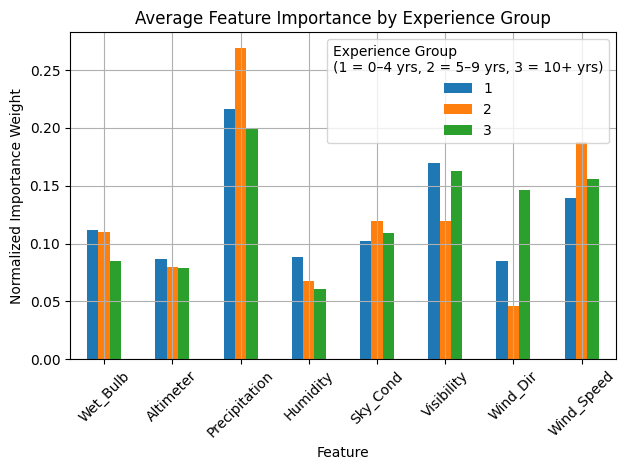

In [ ]:
# ✅ Group by Experience Group (Years)
experience_group_means = full_df.groupby("Years")[expected_features].mean()

# ✅ Plot
plt.figure(figsize=(14,8))
experience_group_means.T.plot(kind='bar')
plt.title("Average Feature Importance by Experience Group")
plt.ylabel("Normalized Importance Weight")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.legend(title="Experience Group\n(1 = 0–4 yrs, 2 = 5–9 yrs, 3 = 10+ yrs)")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

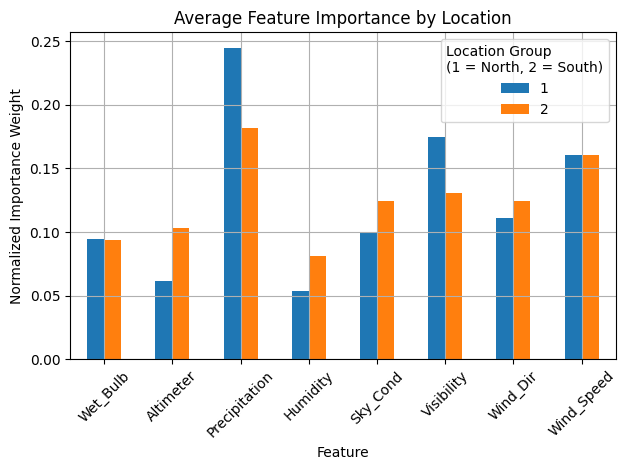

In [ ]:
# ✅ Group by Location
location_group_means = full_df.groupby("Location")[expected_features].mean()

# ✅ Plot
plt.figure(figsize=(14,8))
location_group_means.T.plot(kind='bar')
plt.title("Average Feature Importance by Location")
plt.ylabel("Normalized Importance Weight")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.legend(title="Location Group\n(1 = North, 2 = South)")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

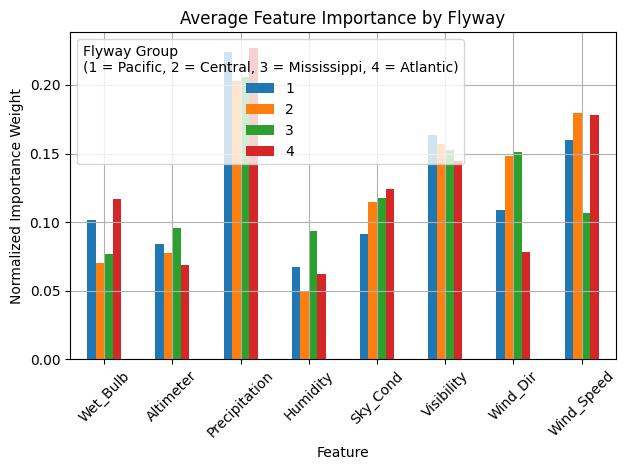

In [ ]:
# ✅ Group by Flyway
flyway_group_means = full_df.groupby("Flyway")[priority_df.columns].mean()

# ✅ Plot
plt.figure(figsize=(14,8))
flyway_group_means.T.plot(kind='bar')
plt.title("Average Feature Importance by Flyway")
plt.ylabel("Normalized Importance Weight")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.legend(title="Flyway Group\n(1 = Pacific, 2 = Central, 3 = Mississippi, 4 = Atlantic)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Analyze the CR by the categories to see if it impacted the AHP
# ✅ Create DataFrame from consistency_ratios
cr_df = pd.DataFrame.from_dict(consistency_ratios, orient="index", columns=["CR"])
cr_df.index.name = "Respondent_ID"

# ✅ Create Metadata DataFrame
metadata_df = pd.DataFrame(metadata_records)
metadata_df.set_index("Respondent_ID", inplace=True)

# ✅ Merge CR with Metadata
cr_full_df = cr_df.merge(metadata_df, left_index=True, right_index=True)

cr_full_df = cr_full_df.sort_index()

# ✅ Preview
print(cr_full_df.head())


                     CR  Years  Location Flyway
Respondent_ID                                  
1              0.843623      3         1      2
10             0.374953      3         1      1
11             0.435429      3         2      4
12             0.506027      3         2      2
13             0.455818      3         1      3


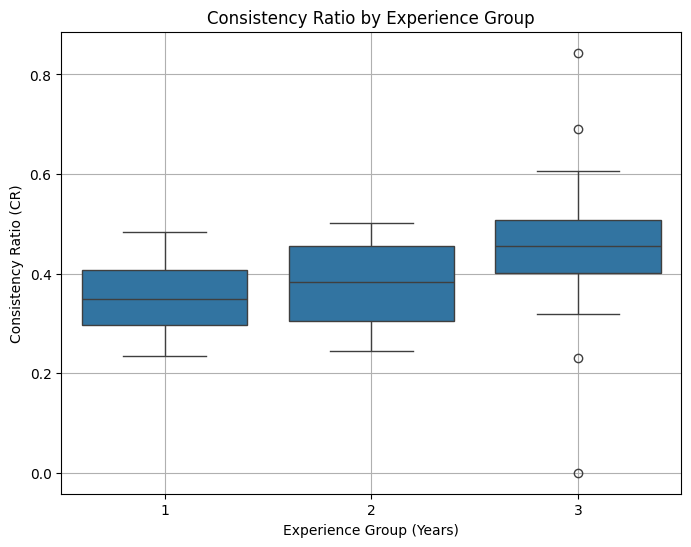

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x="Years", y="CR", data=cr_full_df)
plt.title("Consistency Ratio by Experience Group")
plt.ylabel("Consistency Ratio (CR)")
plt.xlabel("Experience Group (Years)")
plt.grid(True)
plt.show()


In [ ]:
#Statistical test for group differences Kruskal-Wallis Test (Experience Groups)
from scipy.stats import kruskal

# Group the CRs by Experience (Years)
groups = [group["CR"].values for name, group in cr_full_df.groupby("Years")]

# Run Kruskal-Wallis test
stat, p = kruskal(*groups)

print(f"\nKruskal-Wallis H-test for Consistency Ratios by Experience Group:")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")



Kruskal-Wallis H-test for Consistency Ratios by Experience Group:
Statistic = 3.2685, p-value = 0.1951


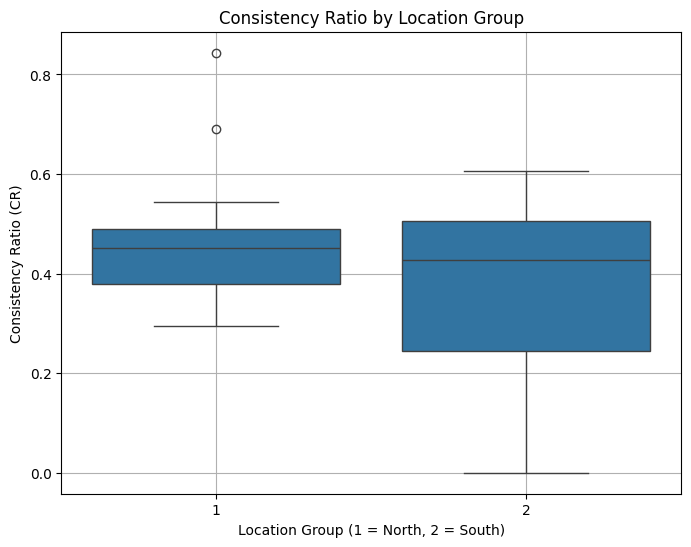

In [ ]:
#North versus South
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x="Location", y="CR", data=cr_full_df)
plt.title("Consistency Ratio by Location Group")
plt.ylabel("Consistency Ratio (CR)")
plt.xlabel("Location Group (1 = North, 2 = South)")
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import kruskal

# ✅ Group the CRs by Location
groups_location = [group["CR"].values for name, group in cr_full_df.groupby("Location")]

# ✅ Kruskal-Wallis test
stat_loc, p_loc = kruskal(*groups_location)

print(f"\nKruskal-Wallis H-test for Consistency Ratios by Location Group:")
print(f"Statistic = {stat_loc:.4f}, p-value = {p_loc:.4f}")



Kruskal-Wallis H-test for Consistency Ratios by Location Group:
Statistic = 1.5077, p-value = 0.2195


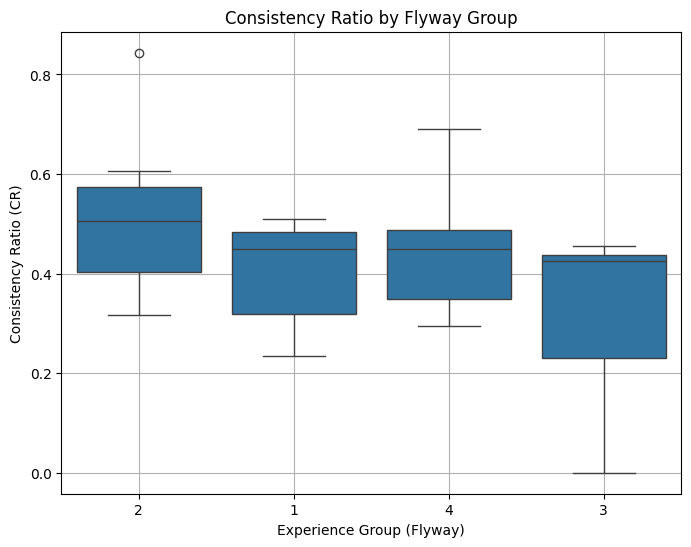

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x="Flyway", y="CR", data=cr_full_df)
plt.title("Consistency Ratio by Flyway Group")
plt.ylabel("Consistency Ratio (CR)")
plt.xlabel("Experience Group (Flyway)")
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import kruskal

# ✅ Group the CRs by flyway
groups_flyway = [group["CR"].values for name, group in cr_full_df.groupby("Flyway")]

# ✅ Kruskal-Wallis test
stat_loc, p_loc = kruskal(*groups_flyway)

print(f"\nKruskal-Wallis H-test for Consistency Ratios by Flyway Group:")
print(f"Statistic = {stat_loc:.4f}, p-value = {p_loc:.4f}")


Kruskal-Wallis H-test for Consistency Ratios by Flyway Group:
Statistic = 4.1590, p-value = 0.2448


In [ ]:
#PCA Check
from sklearn.preprocessing import StandardScaler

# ✅ Standardize the AHP feature weights
scaler = StandardScaler()
X_scaled = scaler.fit_transform(priority_df)

# ✅ Preview shape
print(f"Shape of standardized data: {X_scaled.shape}")



Shape of standardized data: (29, 8)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# ✅ Now create explained_variance
explained_variance = pca.explained_variance_ratio_

# ✅ Print it
print("\nExplained Variance Ratio by Component:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f}")



Explained Variance Ratio by Component:
PC1: 0.2484
PC2: 0.2066
PC3: 0.1699
PC4: 0.1372
PC5: 0.1199
PC6: 0.0830
PC7: 0.0349
PC8: 0.0000


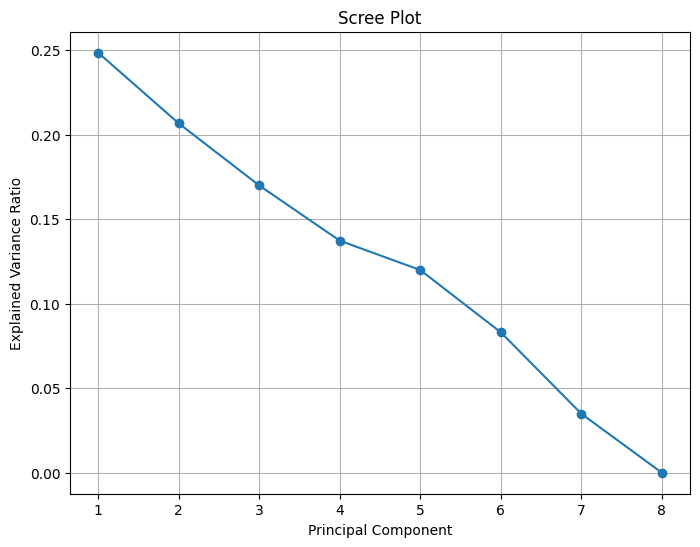

In [ ]:
import matplotlib.pyplot as plt

# ✅ Scree plot
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


In [ ]:
# ✅ PCA Loadings: Feature-to-Component relationships
loadings = pd.DataFrame(pca.components_.T,
                        index=priority_df.columns,
                        columns=[f'PC{i+1}' for i in range(len(priority_df.columns))])

print("\nPCA Feature Loadings:")
print(loadings.round(4))



PCA Feature Loadings:
                  PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8
Wet_Bulb      -0.4067 -0.2472 -0.4252 -0.4571  0.1377  0.1530 -0.4689  0.3486
Altimeter     -0.1048 -0.4615  0.4967  0.3109 -0.1221 -0.4329 -0.4050  0.2575
Precipitation -0.3809  0.5676  0.2066 -0.0729 -0.3156 -0.1001  0.2156  0.5732
Humidity      -0.3673 -0.4887 -0.1615  0.3821  0.0558  0.2455  0.5932  0.1971
Sky_Cond       0.1491 -0.0739  0.4813 -0.3817  0.6881  0.0442  0.2440  0.2450
Visibility     0.1855  0.3201 -0.3092  0.5878  0.4974 -0.0371 -0.2308  0.3465
Wind_Dir       0.5424 -0.1393  0.1137  0.0129 -0.3514  0.6057 -0.1111  0.4131
Wind_Speed     0.4391 -0.1936 -0.4044 -0.2274 -0.1383 -0.5905  0.3043  0.3067


In [ ]:
# ✅ Save Explained Variance Ratios
explained_variance_df = pd.DataFrame({
    "Principal Component": [f"PC{i+1}" for i in range(len(explained_variance))],
    "Explained Variance Ratio": explained_variance
})

explained_variance_df.to_csv("PCA_Explained_Variance_AHP.csv", index=False)

# ✅ Save PCA Loadings
loadings.to_csv("PCA_Loadings_AHP.csv")

# ✅ Download the files
from google.colab import files
files.download("PCA_Explained_Variance_AHP.csv")
files.download("PCA_Loadings_AHP.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

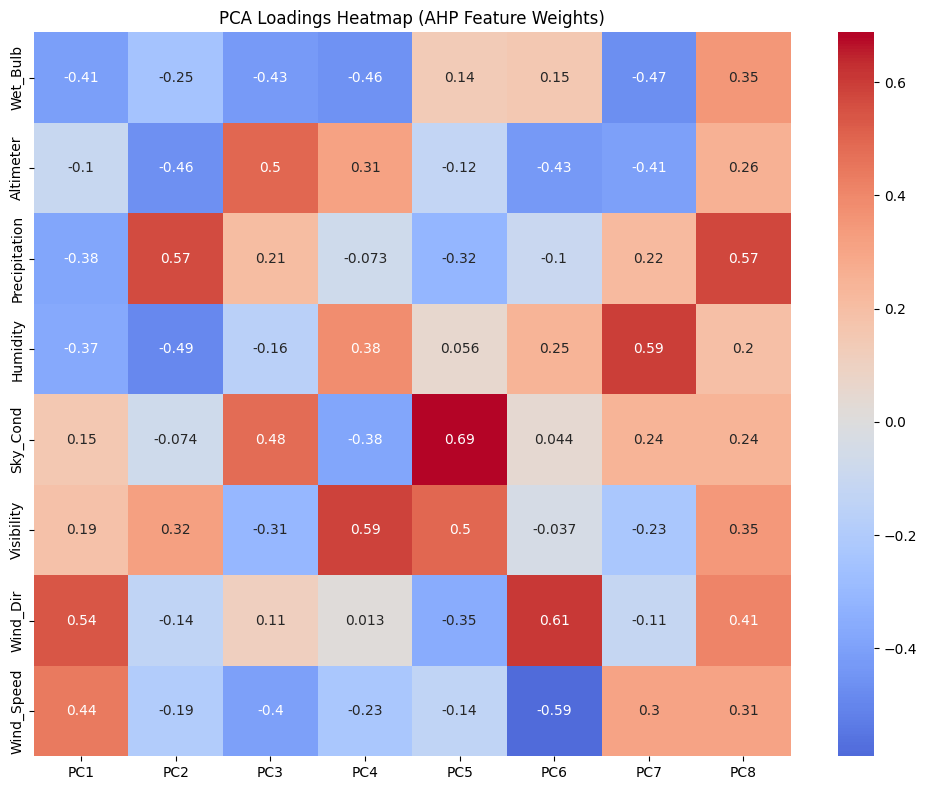

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Heatmap of PCA Loadings
plt.figure(figsize=(10,8))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Loadings Heatmap (AHP Feature Weights)")
plt.tight_layout()
plt.savefig("PCA_Loadings_Heatmap_AHP.png", dpi=300)

# ✅ Download heatmap
files.download("PCA_Loadings_Heatmap_AHP.png")
